# Motion Planning, Assignment 8: Q-Learning with openai gym

Thao Dang, Hochschule Esslingen

In this assignment you will experiment with Q learning for a classic control problem: balancing a pole on a moving cart.

![cartpole.png](https://gymnasium.farama.org/_images/cart_pole.gif)

Note for solution: 
This notebook is based on https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py

# Simulations with openai gym

This assignment will utilize a famous simulation environment for testing reinforcement learning algorithms: https://gymnasium.farama.org/

Pytorch will be used later, so you should run this notebook with a GPU.
To enable GPU's in colab, select 
```bash
"Runtime" > “Change runtime type” > "T4 GPU"
```
after you uploaded the notebook file to colab.

## Test gymnasium environment

First, upload the required additional files to colab (file symbol icon on the left side bar):
- utils.py 

Then, install the necessary modules:

In [ ]:
%%capture cap --no-stderr
!pip install swig
!pip install moviepy
!pip install gymnasium[classic-control]

Now, let's import all relevant packages and define some import functions that help displaying videos on colab.

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import numpy as np
import random
from collections import deque
import torch
import gymnasium as gym
from dataclasses import dataclass, field
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from utils import *

# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
# The flag below controls whether to allow TF32 on matmul. This flag defaults to True.
torch.backends.cuda.matmul.allow_tf32 = False
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = False

# remove old video files (if any)
if os.path.exists('output'):
    os.system('rm -f output/*.mp4')

## The cart pole environment

After everything has been set up, we are ready to try some nice simulations. Here, we will only use the cart pole environment (https://gymnasium.farama.org/environments/classic_control/cart_pole/). The description of this environment is as follows (taken from: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py)

> ## Description
> 
> This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077). A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.
>
>## Action Space
>
>The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
>
>- 0: Push cart to the left
>- 1: Push cart to the right
>
>**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it
>
>## Observation Space
>
>The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
>
>| Num | Observation           | Min                 | Max               |
>|-----|-----------------------|---------------------|-------------------|
>| 0   | Cart Position         | -4.8                | 4.8               |
>| 1   | Cart Velocity         | -Inf                | Inf               |
>| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
>| 3   | Pole Angular Velocity | -Inf                | Inf               |
>
>**Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
>-  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
>-  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)
>
>## Rewards
>Since the goal is to keep the pole upright for as long as possible, by default, a reward of `+1` is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.
>
>If `sutton_barto_reward=True`, then a reward of `0` is awarded for every non-terminating step and `-1` for the terminating step. As a result, the reward threshold is 0 for v0 and v1.
>
>## Starting State
>All observations are assigned a uniformly random value in `(-0.05, 0.05)`
>
>## Episode End
>The episode ends if any one of the following occurs:
>
>1. Termination: Pole Angle is greater than ±12°
>2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
>3. Truncation: Episode length is greater than 500 (200 for v0)

To run this simulation, the following class ``CartPoleBase`` may be useful. It provides two important functions:
* ``act``: the standard policy function that generates an action from the current state data (you will overwrite this function later), and
* ``run``: which runs and renders a simulation once ``act`` has been defined.

In [2]:
class CartPoleBase():
    def __init__(self, max_steps=200):
        """
        The constructor.
        max_steps is the max number of steps to take (given that the trial does not fail before)
        """
        self.max_steps = max_steps
        self.env = gym.make('CartPole-v1', render_mode = "rgb_array")
        self.env = RenderFrame(self.env, "./output")
        
        
    def act(self, observation, reward, done):
        """
        A very simple agent that randomly chooses an action.
        
        Arguments (everything the simulator provides): 
            observation: the observed state (Cart Position, Cart Velocity, Pole Angle, 
                         Pole Angular Velocity)
            reward:      1 for every step taken
            done:        true if simulation terminated
    
        Return:
            0 to push cart to the left, 1 to push cart to the right
        """
        assert False, "not implemented yet"
        return 0 
        

    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        t = 0
        reward = 0
        done = False
        obs, _ = self.env.reset()
        
        while t < self.max_steps:
            t = t+1
            action = self.act(obs, reward, done)
            obs, reward, terminated, truncated, _ = self.env.step(action)
                
            if terminated or truncated:
                break
        
        self.env.release()
        self.env.play()
        return t
    

# Exercise 1: Random policy

Let's first try everything we have installed so far by running an agent that chooses actions at random and render the scene. You will only have to add one line here.

In [3]:
class CartPoleRandom(CartPoleBase):
    def act(self, observation, reward, done):
        """
        A very simple agent that randomly chooses an action.
        
        Arguments (everything the simulator provides): 
            observation: the observed state (Cart Position, Cart Velocity, Pole Angle, 
                         Pole Angular Velocity)
            reward:      1 for every step taken
            done:        true if simulation terminated
    
        Return:
            0 to push cart to the left, 1 to push cart to the right
        """
        ## TODO: Add your code here 
        return self.env.action_space.sample()

In [4]:
randomAgent = CartPoleRandom()
steps_taken = randomAgent.run()
print('Finished after %d steps.' % steps_taken)

Finished after 25 steps.


# Exercise 2: Q-learning

Next, you will use Q-learning based on the Bellmann equation as described in the lecture to find a **Q-value function** or **Q-table** that estimates the maximum expected cumulative reward achievable
from a given (state, action) pair.

A Q-table is discrete in its nature, yet the problem we are considering here is continous since the observations that we make (cart position, cart velocity, pole angle, pole angular velocity) are continous, real numbers. To still be able to use Q-learning, we need to **discretize** our system. This is done by quantisation of all observations in separate buckets (or bins) and refering to them by the index of the bucket in which they belong.
E.g. if we know that cart velocity is always within the range -0.5..0.5 and we want to use four bins for discretization, we could transform the real-valued cart velocity $v$ to a discrete value $v_d=0$ if $v < -0.25$, to $v_d=1$ if $-0.25 \leq v < 0$, to $v_d=2$ if $0 \leq v < 0.25$, and to $v_d=3$ if $v \geq 0.5$. Using such a discretization, our cart pole problem becomes computationally tractable for the Q-learning algorithm.  

The Q-learning algorithm that you will implement here is a slightly modified version from the algorithm given in the lecture:

> **Given**: rewards $r$, discount factor $\gamma$, learning rate $\alpha$, probability threshold $\epsilon$
>
> **Algorithm**:
> 1. Initialize Q-table to zero.
> 2. For each episode (a.k.a. training session):
>> 3. Select (random) initial state $s_t$.
>> 4. Do while the goal state hasn't been reached:
>>> 5. If random number $p<\epsilon$: Randomly select one action $a_t$ among all possible actions for the current state $s_t$. Otherwise: Select best action based on current Q-table. Both actions result in next state $s_{t+1}$.
>>> 6. Update expected cumulative reward: $$Q(s_t, a_t) \leftarrow (1−\alpha) 𝑄(s_t, a_t) + \alpha \left[ r(s_t, a_t) + \gamma max_{a}⁡ \{ Q(s_{t+1}, a) \} \right]$$
>>> 7. Set the next state as the current state $s_t \leftarrow s_{t+1}$

## Exercise 2.1: Algorithm

What is the major difference between the algorithm shown above and the version presented in the lecture. What are potential reasons behind this modification?

In the algorithm above, it is common to adapt the learning rate and epsilon with the episodes. How and why would you modify these parameters? 

The following class is a skeleton for implemening the Q-learning algorithm.

In [5]:
class CartPoleQAgent(CartPoleBase):
    def __init__(self, num_bins=(3, 3, 6, 6), 
                 num_episodes=300, min_lr=0.1, 
                 min_epsilon=0.1, discount=1.0, decay=25):
        """
        The constructor.
        Arguments:
            num_bins: the number of bins for discretization of all four observations
            num_episodes: number of episodes to train
            min_lr: minimum learning rate
            min_epsilon: minimum epsilon value (used for sampling random actions)
            discount: discount factor
            decay: a decay factor used for adaptation of the learning rate and epsilon
        """
        CartPoleBase.__init__(self)
        
        self.num_episodes = num_episodes
        self.num_bins = num_bins
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        
        # action-value function initialized with 0's
        # the Q-table has shape "num_bins[0] x num_bins[1] x num_bins[2] x num_bins[3] x 2"
        self.Q_table = np.zeros(self.num_bins + (self.env.action_space.n,))

        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], np.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -np.radians(50) / 1.]
        
        # bins for discretization
        self.bins = []
        for low, high, num in zip(self.lower_bounds, self.upper_bounds, self.num_bins):
            delta = (high-low)/num
            b = [low+(i+1)*delta for i in range(num-1)]
            self.bins.append(b)
        
        # book keeping of steps taken in each episode
        self.steps = np.zeros(self.num_episodes)
        

    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the 
        Q-table can be smaller and more easily filled.
        
        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.
        
        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller 
                             than n where n is the number in the same position
                             in the num_bins list.
        """
        discretized = list()
        for i in range(len(obs)):
            new_obs = np.digitize(obs[i], self.bins[i])
            discretized.append(new_obs)
        
        return tuple(discretized)


    def decay_function(self, t, min_val):
        """
        A decay function for modelling learning rate and epsilon in training function.
        Arguments:
            t: num epochs
            min_val: returned decay value is never smaller than this
        """
        return max(min_val, min(1., 1. - np.log10((t + 1) / self.decay)))

    
    def train(self):
        """
        Implements the Q-learning algorithm as described in the text above.
        """
        # pause video generation
        self.env.pause()
        
        # Looping for each episode
        for e in tqdm(range(self.num_episodes)):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset()[0])

            # decaying learning rate and epsilon 
            self.learning_rate = self.decay_function(e, self.min_lr)
            self.epsilon = self.decay_function(e, self.min_epsilon)
            
            # Looping for each step
            while True:
                self.steps[e] += 1
                
                ## TODO: Add your code here
                
                # choose action from state
                if (np.random.random() < self.epsilon):
                    action = self.env.action_space.sample() 
                else:
                    action = np.argmax(self.Q_table[current_state])
        
                # Take action
                obs, reward, terminated, truncated, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                
                # Update Q(S,A)
                self.Q_table[current_state][action] = (1-self.learning_rate) * self.Q_table[current_state][action] + \
                    self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]))
                
                current_state = new_state
                
                # We break out of the loop when done:
                if terminated or truncated:
                    break
        print('Finished training!')
        
        # resume video generation
        self.env.resume()
        
    
    def plot_learning(self):
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(x=range(len(self.steps)), y=self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] >= self.max_steps-1:
                t+=1
        print(t, " episodes were successfully completed.")
        
        
    def act(self, observation, reward, done):
        """
        A Q-learning based agent.
        
        Arguments (everything the simulator provides): 
            observation: the observed state (Cart Position, Cart Velocity, Pole Angle, 
                         Pole Angular Velocity)
            reward:      1 for every step taken
            done:        true if simulation terminated
    
        Return:
            0 to push cart to the left, 1 to push cart to the right
        """
        
        ## TODO: Add your code here
        state = self.discretize_state(observation)
        return np.argmax(self.Q_table[state])

## Exercise 2.2: Training

Implement the ``train`` function above and run the training using the code below.

  0%|          | 0/300 [00:00<?, ?it/s]

Finished training!


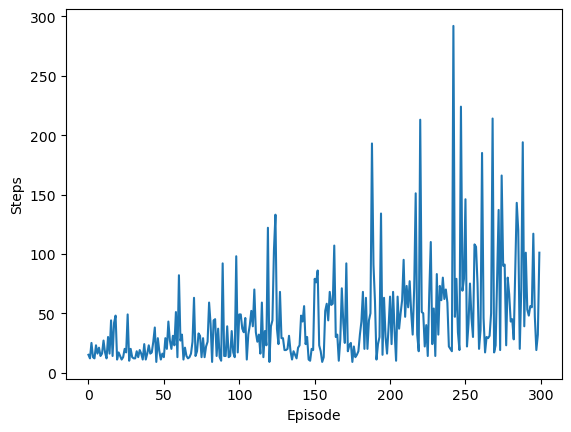

4  episodes were successfully completed.


In [6]:
agent = CartPoleQAgent()
agent.train()
agent.plot_learning()

## Exercise 2.3: Evaluation

Implement the ``act`` function above and see how your trained policy performs.

Try modifying the hyperparameters (learning rate, epsilon, ...) of the algorithm and compare performances.

In [7]:
steps_taken = agent.run()
print('Finished after %d steps.' % steps_taken)

Finished after 56 steps.


# Exercise 3: Deep Q-learning (optional)

As an optional exercise, you can study a deep Q-network as an alternative solution to the cart pole problem.

A Q-network does not require a discretization of the state space, but as you will see, it can take quite a while to learn. You can try to run the following code in Colab and even use a GPU for training.

The code below has been adapted from [here](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter9-drl/dqn-cartpole-9.6.1.py). It uses two "tricks" that are helpful when training a deep Q-network:

1. **Replay memory**: As decribed in the lecture slides, learning from batches of consecutive simulation samples is problematic: Consecutive samples in time are presumably highly correlated. This correlation in training batches leads to inefficient training and may bias the result. To deal with this problem, it is advisable to establish a replay memory and then sample (non-consecutive) state-action data points from this memory.

2. **Target networks**: In Q-Learning, we update "a guess with a guess" which can lead to unstable results. The Bellman equation defines a relationship between Q(s(t), a(t)) and Q(s(t+1), a(t+1)). Altering Q(s(t), a(t)) may influence Q(s(t+1), a(t+1)) and other states nearby, leading to fluctuations in the training results. To overcome this effect, a copy of the network is used to compute Q(s(t+1), a(t+1)). This copy is not trained, but only periodically synced to the main network.

More information on both measures can be found [here](https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c).

Study the code below and add a three layer fully connected network (each layer with 256 nodes and ReLU activation). 
Find the replay memory and target network implementations. Run the network (this may take a while, you may start with smaller networks at first), and check the results of the network.


In [8]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepQLearningNetwork(torch.nn.Module):
    def __init__(self, action_space, observation_space):
        """
        Implementation of the network layers.
        """
        super().__init__()
                
        self.n_inputs = observation_space.shape[0]
        self.n_outputs = action_space.n
        
        # TODO: Add your code here
        # Start with a simple network with 3 hidden layers of 256 neurons each and add ReLU activation functions
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.n_outputs)
        ).to(device)

    def forward(self, observation):
        """
        The forward pass of the network. Returns the prediction for the given
        input observation.
        observation:   torch.Tensor of size (batch_size, n_inputs)
        return         torch.Tensor of size (batch_size, n_outputs)
        """
        batch_size = observation.shape[0]

         # TODO: Add your code here
        obs = observation.reshape(batch_size, self.n_inputs)
        return self.layers(obs)

    def scores_to_action(self, scores):
        """
        Maps the scores predicted by the network to an action-class.
        scores:         python list of torch.Tensors of size n_outputs
        return          0 to push cart to the left, 1 to push cart to the right
        """
        _, class_number = torch.max(scores[0], dim=0)  
        return class_number

    
print(DeepQLearningNetwork(action_space=agent.env.action_space, observation_space=agent.env.observation_space))

DeepQLearningNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [59]:
class DQNAgent(CartPoleBase):
    def __init__(self, num_episodes=500):
        """DQN Agent on CartPole-v0 environment

        Arguments:
            num_episodes (int): max number of episodes to train
        """
        CartPoleBase.__init__(self)
       
        self.num_episodes = num_episodes 
        self.action_space = self.env.action_space

        # experience buffer
        self.memory = []

        # discount rate
        self.gamma = 0.9

        # initially 90% exploration, 10% exploitation
        self.epsilon = 1.0
        # iteratively applying decay til 
        # 10% exploration/90% exploitation
        self.epsilon_min = 0.1
        self.epsilon_decay = self.epsilon_min / self.epsilon
        self.epsilon_decay = self.epsilon_decay ** (1. / float(500))

        # Q Network weights filename
        self.weights_file = "agent.pth"
        
        # Q Network for training
        self.q_model = DeepQLearningNetwork(action_space=agent.env.action_space, observation_space=agent.env.observation_space)

        self.learning_rate = 0.001
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=self.learning_rate)
        self.loss_fn = torch.nn.MSELoss()

        # target Q Network
        self.target_q_model = DeepQLearningNetwork(action_space=agent.env.action_space, observation_space=agent.env.observation_space)
        # copy Q Network params to target Q Network
        self.update_weights()

        self.replay_counter = 0

    def save_weights(self):
        """save Q Network params to a file"""
        torch.save(self.q_model, self.weights_file)
        
    def load_weights(self):
        """load Q Network params to a file"""
        self.q_model = torch.load(self.weights_file, map_location=device)        
        
    def update_weights(self):
        """copy trained Q Network params to target Q Network"""
        self.target_q_model.load_state_dict(self.q_model.state_dict())
        
    def remember(self, state, action, reward, next_state, done):
        """store experiences in the replay buffer
        Arguments:
            state (tensor): env state
            action (tensor): agent action
            reward (float): reward received after executing action on state
            next_state (tensor): next state
        """
        item = (state, action, reward, next_state, done)
        self.memory.append(item)

    def get_target_q_value(self, next_state, reward):
        """compute Q_max
           Use of target Q Network solves the non-stationarity problem
        Arguments:
            reward (float): reward received after executing  action on state
            next_state (tensor): next state
        Return:
            q_value (float): max Q-value computed
        """
        # max Q value among next state's actions
        # DQN chooses the max Q value among next actions
        # selection and evaluation of action is on the target Q Network
        # Q_max = max_a' Q_target(s', a')
        q_values = self.target_q_model(torch.Tensor(next_state).to(device))
        q_value = torch.max(q_values).item()

        # Q_max = reward + gamma * Q_max
        q_value *= self.gamma
        q_value += reward
        return q_value

    def replay(self, batch_size):
        """experience replay addresses the correlation issue between samples
        Arguments:
            batch_size (int): replay buffer batch sample size
        """
        # sars = state, action, reward, state' (next_state)
        sars_batch = random.sample(self.memory, batch_size)
        state_batch, q_values_batch = [], []

        # fixme: for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for state, action, reward, next_state, done in sars_batch:
            # policy prediction for a given state
            q_values = self.target_q_model(torch.Tensor(state).to(device))

            # get Q_max
            q_value = self.get_target_q_value(next_state, reward)

            # correction on the Q value for the action used
            q_values[0][action] = reward if done else q_value

            # collect batch state-q_value mapping
            state_batch.append(torch.tensor(state).to(device))
            q_values_batch.append(torch.tensor(q_values).to(device))

        # train the Q-network
        self.q_model.train()
        batch_in = torch.reshape(torch.cat(state_batch, dim=0), (-1, self.q_model.n_inputs))
        batch_gt = torch.reshape(torch.cat(q_values_batch, dim=0), (-1, self.q_model.n_outputs))

        assert batch_in.shape[0] == batch_size
        assert batch_in.shape[1] == self.q_model.n_inputs
        assert batch_gt.shape[0] == batch_size
        assert batch_gt.shape[1] == self.q_model.n_outputs
        
        batch_out = self.q_model(batch_in)
        loss = self.loss_fn(batch_out, batch_gt)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.q_model.eval()

        # update exploration-exploitation probability
        self.update_epsilon()

        # copy new params on old target after every 10 training updates
        if self.replay_counter % 10 == 0:
            self.update_weights()

        self.replay_counter += 1

    
    def update_epsilon(self):
        """decrease the exploration, increase exploitation"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        
    def train(self):
        # pause video generation
        self.env.pause()
        
        # the number of trials without falling over
        win_trials = 100

        # the CartPole is considered solved if 
        # for 100 consecutive trials, he cart pole has not 
        # fallen over and it has achieved an average 
        # reward of 195.0 
        # a reward of +1 is provided for every timestep 
        # the pole remains upright
        win_reward = 195.0

        # stores the reward per episode
        scores = deque(maxlen=win_trials)

        state, _ = self.env.reset(seed=0)

        # should be solved in this number of episodes
        episode_count = self.num_episodes
        state_size = self.env.observation_space.shape[0]
        batch_size = 64
        
        self.q_model.eval()

        # by default, CartPole-v0 has max episode steps = 200
        # you can use this to experiment beyond 200
        # env._max_episode_steps = 4000

        # Q-Learning sampling and fitting
        for episode in tqdm(range(episode_count)):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, state_size])
            done = False
            total_reward = 0
            while not done:
                # in CartPole-v1, action=0 is left and action=1 is right
                if np.random.rand() < self.epsilon:
                    # explore - do random action
                    action = self.action_space.sample()
                else:
                    # exploit
                    q_values = self.q_model(torch.Tensor(state).to(device))
                    # select the action with max Q-value
                    action = torch.argmax(q_values, dim=1).item()
                
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                # in CartPole-v1:
                # state = [pos, vel, theta, angular speed]
                next_state = np.reshape(next_state, [1, state_size])
                # store every experience unit in replay buffer
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward


            # call experience replay
            if len(self.memory) >= batch_size:
                self.replay(batch_size)

            scores.append(total_reward)
            mean_score = np.mean(scores)
            if mean_score >= win_reward and episode >= win_trials:
                print("Solved in episode %d: Mean survival = %0.2lf in %d episodes" % (episode, mean_score, win_trials))
                print("Epsilon: ", self.epsilon)
                break
            if (episode + 1) % win_trials == 0:
                tqdm.write("Episode %d: Mean survival = %0.2lf in %d episodes" %  ((episode + 1), mean_score, win_trials))

        # close the env 
        self.env.close()
        
        # resume video generation
        self.env.resume()         
        
        
    def act(self, observation, reward, done):
        """
        An deep Q-learning based agent.
        
        Arguments (everything the simulator provides): 
            observation: the observed state (Cart Position, Cart Velocity, Pole Angle, 
                         Pole Angular Velocity)
            reward:      1 for every step taken
            done:        true if simulation terminated
    
        Return:
            0 to push cart to the left, 1 to push cart to the right
        """
        state_size = self.env.observation_space.shape[0]
        state = np.reshape(observation, [1, state_size])
        q_values = self.target_q_model(torch.Tensor(state).to(device))
        # select the action with max Q-value
        action = torch.argmax(q_values, dim=1).item()
        return action


Run training untill either a max number of iterations is reached or until the performance in the last 100 trials was good enough. You may need to adjust the max number of iterations.

In [60]:
dqnagent = DQNAgent()
dqnagent.train()
dqnagent.save_weights()

  0%|          | 0/500 [00:00<?, ?it/s]

Episode 100: Mean survival = 24.94 in 100 episodes
Episode 200: Mean survival = 39.46 in 100 episodes
Episode 300: Mean survival = 182.47 in 100 episodes
Solved in episode 304: Mean survival = 195.07 in 100 episodes
Epsilon:  0.2500345361696452


Finally, run sample trials with the trained network:

In [61]:
dqnagent.load_weights()
dqnagent.update_weights()
steps_taken = dqnagent.run()
print('Finished after %d steps.' % steps_taken)

Finished after 200 steps.
